# Convolution neural network 

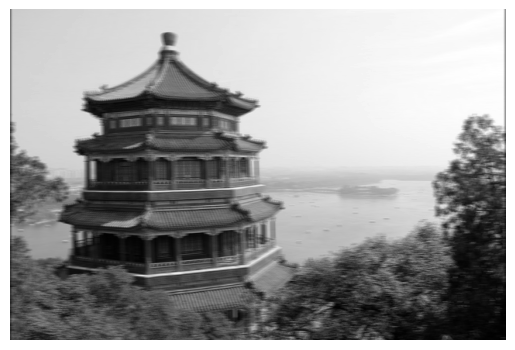

In [55]:
import tensorflow as tf 
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np 
import sklearn
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.datasets import load_sample_image

china = load_sample_image("china.jpg") / 255
flower = load_sample_image("flower.jpg") / 255
images = np.array([china, flower])
batch_size, height, width, channels = images.shape

filters = np.zeros(shape=(7, 7, channels, 2), dtype=np.float32)
filters[:, 3, :, 0] = 1  # vertical line
filters[3, :, :, 1] = 1  # horizontal line

outputs = tf.nn.conv2d(images, filters, strides=1, padding="SAME")

plt.imshow(outputs[0, :, :, 1], cmap="gray")
plt.axis("off")
plt.show()



In [56]:
def plot_image(image):
    plt.imshow(image, cmap="gray", interpolation="nearest")
    plt.axis("off")

def plot_color_image(image):
    plt.imshow(image, interpolation="nearest")
    plt.axis("off")

In [58]:
def crop(images):
    return images[150:220, 130:250]

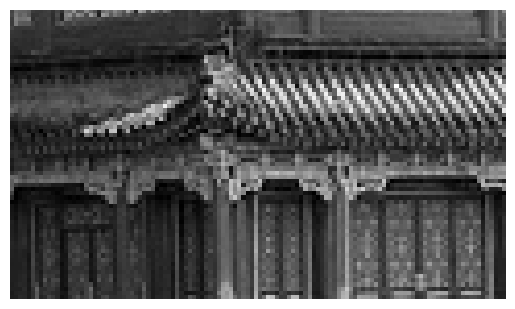

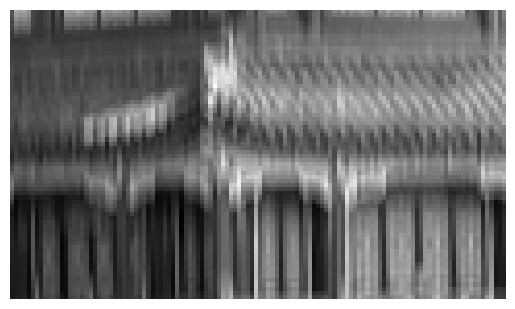

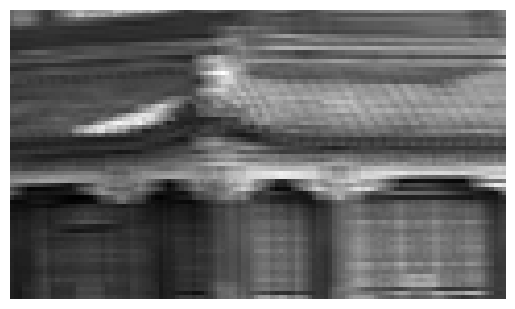

In [59]:
plot_image(crop(images[0, :, :, 0]))
plt.show()

for feature_map_index, filename in enumerate(["china_vertical", "china_horizontal"]):
    plot_image(crop(outputs[0, :, :, feature_map_index]))
    plt.show()

## Convolution

In [60]:

conv = keras.layers.Conv2D(filters=2, kernel_size=7, strides=1,
                           padding="SAME", activation="relu", input_shape=outputs.shape)

In [61]:
conv_outputs = conv(images)
conv_outputs.shape 

TensorShape([2, 427, 640, 2])

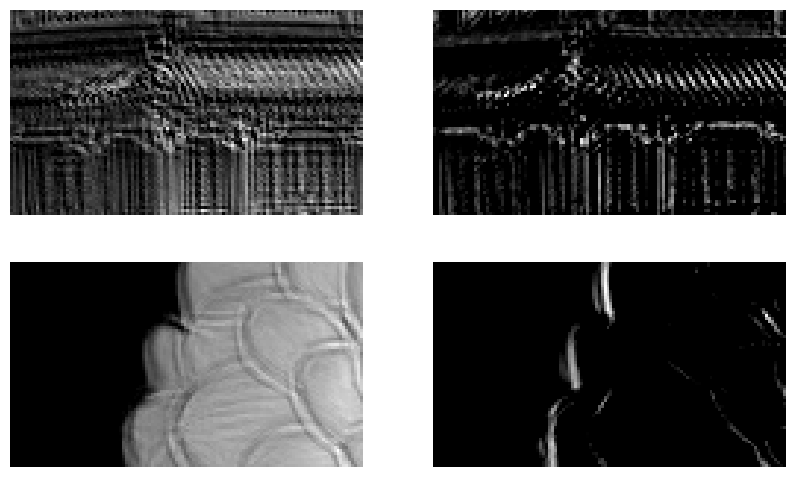

In [62]:
plt.figure(figsize=(10,6))
for image_index in (0, 1):
    for feature_map_index in (0, 1):
        plt.subplot(2, 2, image_index * 2 + feature_map_index + 1)
        plot_image(crop(conv_outputs[image_index, :, :, feature_map_index]))
plt.show()

In [ ]:
conv.set_weights([filters, np.zeros(2)])

In [64]:
conv_outputs = conv(images)
conv_outputs.shape 

TensorShape([2, 427, 640, 2])

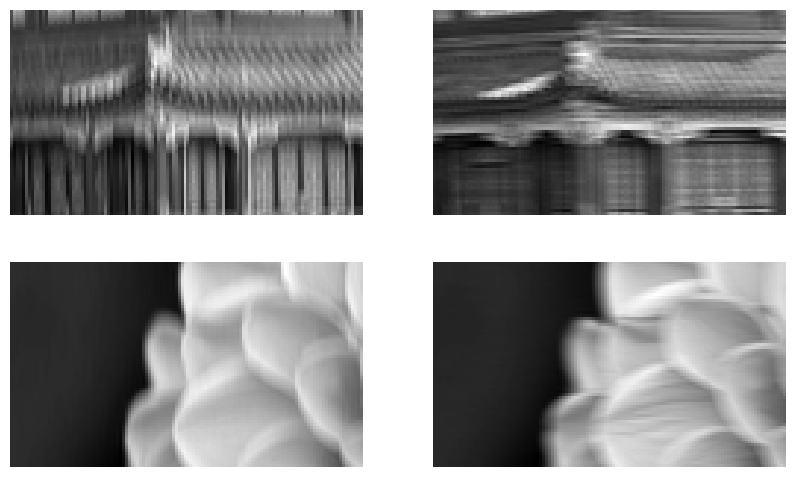

In [65]:
plt.figure(figsize=(10,6))
for image_index in (0, 1):
    for feature_map_index in (0, 1):
        plt.subplot(2, 2, image_index * 2 + feature_map_index + 1)
        plot_image(crop(conv_outputs[image_index, :, :, feature_map_index]))
plt.show()

## Pooling

### Max pooling

In [66]:
max_pool = keras.layers.MaxPool2D(pool_size=2)
cropped_images = np.array([crop(image) for image in images], dtype=np.float32)
output = max_pool(cropped_images)


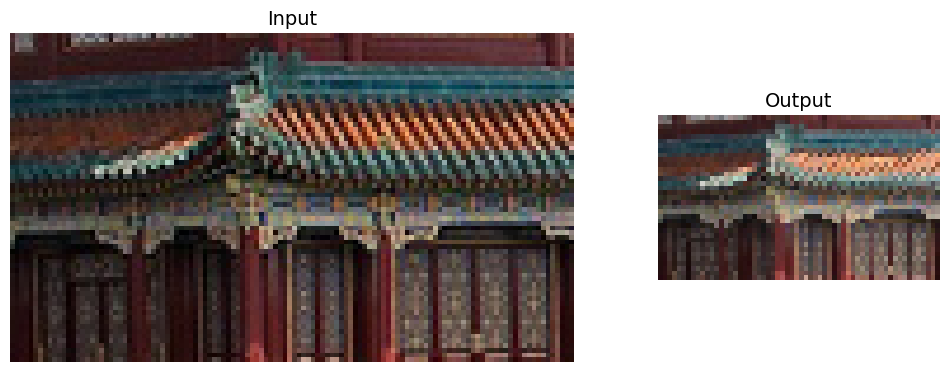

In [67]:
fig = plt.figure(figsize=(12, 8))
gs = mpl.gridspec.GridSpec(nrows=1, ncols=2, width_ratios=[2, 1])

ax1 = fig.add_subplot(gs[0, 0])
ax1.set_title("Input", fontsize=14)
ax1.imshow(cropped_images[0])  # plot the 1st image
ax1.axis("off")
ax2 = fig.add_subplot(gs[0, 1])
ax2.set_title("Output", fontsize=14)
ax2.imshow(output[0])  # plot the output for the 1st image
ax2.axis("off")
plt.show()

### depth wise pooling

In [ ]:
class DepthMaxPool(keras.layers.Layer):
    def __init__(self, pool_size, strides=None, padding="VALID", **kwargs):
        super().__init__(**kwargs)
        if strides is None:
            strides = pool_size
        self.pool_size = pool_size
        self.strides = strides
        self.padding = padding
    def call(self, inputs):
        return tf.nn.max_pool(inp
                              ksize=(1, 1, 1, self.pool_size),
                              strides=(1, 1, 1, self.pool_size),
                              padding=self.padding)

In [69]:
depth_pool = DepthMaxPool(3)
with tf.device("/cpu:0"): # there is no GPU-kernel yet
    depth_output = depth_pool(cropped_images)
depth_output.shape

TensorShape([2, 70, 120, 1])

In [70]:
depth_pool = keras.layers.Lambda(lambda X: tf.nn.max_pool(
    X, ksize=(1, 1, 1, 3), strides=(1, 1, 1, 3), padding="VALID"))
with tf.device("/cpu:0"): # there is no GPU-kernel yet
    depth_output = depth_pool(cropped_images)
depth_output.shape

TensorShape([2, 70, 120, 1])

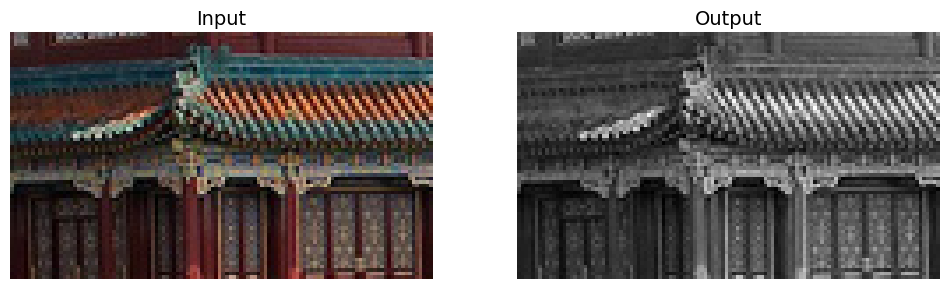

In [71]:
plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.title("Input", fontsize=14)
plot_color_image(cropped_images[0])  # plot the 1st image
plt.subplot(1, 2, 2)
plt.title("Output", fontsize=14)
plot_image(depth_output[0, ..., 0])  # plot the output for the 1st image
plt.axis("off")
plt.show()

### average pooling

In [72]:
avg_pool = keras.layers.AvgPool2D(pool_size=2)


In [73]:
output_avg = avg_pool(cropped_images)


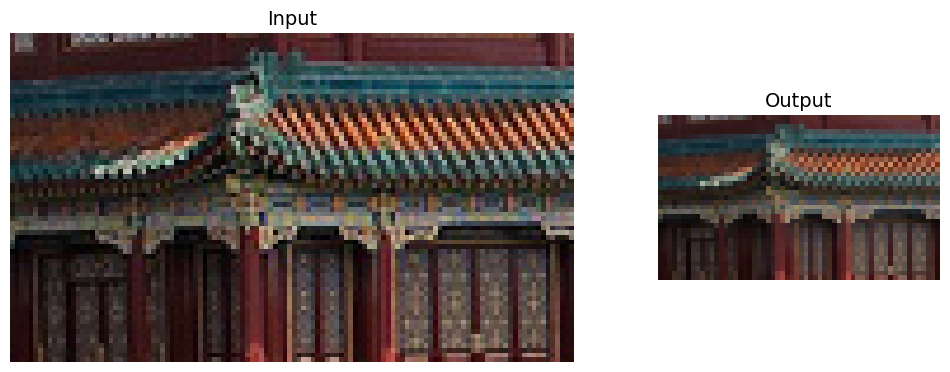

In [74]:
fig = plt.figure(figsize=(12, 8))
gs = mpl.gridspec.GridSpec(nrows=1, ncols=2, width_ratios=[2, 1])

ax1 = fig.add_subplot(gs[0, 0])
ax1.set_title("Input", fontsize=14)
ax1.imshow(cropped_images[0])  # plot the 1st image
ax1.axis("off")
ax2 = fig.add_subplot(gs[0, 1])
ax2.set_title("Output", fontsize=14)
ax2.imshow(output_avg[0])  # plot the output for the 1st image
ax2.axis("off")
plt.show()

## Fashion MNIST Convolution network

In [75]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

X_mean = X_train.mean(axis=0, keepdims=True)
X_std = X_train.std(axis=0, keepdims=True) + 1e-7
X_train = (X_train - X_mean) / X_std
X_valid = (X_valid - X_mean) / X_std
X_test = (X_test - X_mean) / X_std

X_train = X_train[..., np.newaxis]
X_valid = X_valid[..., np.newaxis]
X_test = X_test[..., np.newaxis]

In [35]:
from functools import partial

DefaultConv2D = partial(keras.layers.Conv2D,
                        kernel_size=3, activation='relu', padding="SAME")

model = keras.models.Sequential([
    DefaultConv2D(filters=64, kernel_size=7, input_shape=[28, 28, 1]),
    keras.layers.MaxPooling2D(pool_size=2),
    DefaultConv2D(filters=128),
    DefaultConv2D(filters=128),
    keras.layers.MaxPooling2D(pool_size=2),
    DefaultConv2D(filters=256),
    DefaultConv2D(filters=256),
    keras.layers.MaxPooling2D(pool_size=2),
    keras.layers.Flatten(),
    keras.layers.Dense(units=128, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units=64, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units=10, activation='softmax'),
])

In [77]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid))
score = model.evaluate(X_test, y_test)
X_new = X_test[:10] # pretend we have new images
y_pred = model.predict(X_new)

Epoch 1/10
1719/1719 [==============================] - 382s 221ms/step - loss: 0.7269 - accuracy: 0.7462 - val_loss: 0.4211 - val_accuracy: 0.8644
Epoch 2/10
1719/1719 [==============================] - 395s 230ms/step - loss: 0.4414 - accuracy: 0.8515 - val_loss: 0.3237 - val_accuracy: 0.8824
Epoch 3/10
1719/1719 [==============================] - 421s 245ms/step - loss: 0.3811 - accuracy: 0.8708 - val_loss: 0.3028 - val_accuracy: 0.8876
Epoch 4/10
1719/1719 [==============================] - 430s 250ms/step - loss: 0.3450 - accuracy: 0.8820 - val_loss: 0.3099 - val_accuracy: 0.8872
Epoch 5/10
1719/1719 [==============================] - 405s 236ms/step - loss: 0.3283 - accuracy: 0.8887 - val_loss: 0.2741 - val_accuracy: 0.8986
Epoch 6/10
1719/1719 [==============================] - 392s 228ms/step - loss: 0.3052 - accuracy: 0.8963 - val_loss: 0.2824 - val_accuracy: 0.8978
Epoch 7/10
1719/1719 [==============================] - 394s 229ms/step - loss: 0.2940 - accuracy: 0.9002 - val_

In [78]:
model.save('convolution_fashion_MNIST.h5')

c:\Users\Jean\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [79]:
from tensorflow.keras.models import load_model

loaded_model = load_model('convolution_fashion_MNIST.h5')

accuracy = loaded_model.evaluate(X_test, y_test)[1]
print(f'Loaded Model Accuracy: {accuracy}')


313/313 [==============================] - 13s 41ms/step - loss: 0.3049 - accuracy: 0.8955
Loaded Model Accuracy: 0.8955000042915344


## ResNet-34

In [36]:
DefaultConv2D = partial(keras.layers.Conv2D, kernel_size=3, strides=1,
                        padding="SAME", use_bias=False)

class ResidualUnit(keras.layers.Layer):
    def __init__(self, filters, strides=1, activation="relu", **kwargs):
        super().__init__(**kwargs)
        self.activation = keras.activations.get(activation)
        self.main_layers = [
            DefaultConv2D(filters, strides=strides),
            keras.layers.BatchNormalization(),
            self.activation,
            DefaultConv2D(filters),
            keras.layers.BatchNormalization()]
        self.skip_layers = []
        if strides > 1:
            self.skip_layers = [
                DefaultConv2D(filters, kernel_size=1, strides=strides),
                keras.layers.BatchNormalization()]

    def call(self, inputs):
        Z = inputs
        for layer in self.main_layers:
            Z = layer(Z)
        skip_Z = inputs
        for layer in self.skip_layers:
            skip_Z = layer(skip_Z)
        return self.activation(Z + skip_Z)

In [37]:
model = keras.models.Sequential()
model.add(DefaultConv2D(64, kernel_size=7, strides=2,
                        input_shape=[224, 224, 3]))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation("relu"))
model.add(keras.layers.MaxPool2D(pool_size=3, strides=2, padding="SAME"))
prev_filters = 64
for filters in [64] * 3 + [128] * 4 + [256] * 6 + [512] * 3:
    strides = 1 if filters == prev_filters else 2
    model.add(ResidualUnit(filters, strides=strides))
    prev_filters = filters
model.add(keras.layers.GlobalAvgPool2D())
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(10, activation="softmax"))

In [38]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 112, 112, 64)      9408      
                                                                 
 batch_normalization_4 (Bat  (None, 112, 112, 64)      256       
 chNormalization)                                                
                                                                 
 activation (Activation)     (None, 112, 112, 64)      0         
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 56, 56, 64)        0         
 g2D)                                                            
                                                                 
 residual_unit (ResidualUni  (None, 56, 56, 64)        74240     
 t)                                                              
                                                      

## Xception model for transfer learning

In [40]:
import os
import shutil
import random

# Path to the original dataset
original_dir = r"C:\Users\Jean\Documents\Suede\Deep_learning\Assignment_4\dataset\flower_photos"

# Path to the new base directory for split datasets
base_dir = r"C:\Users\Jean\Documents\Suede\Deep_learning\Assignment_4\split_dataset"

# Classes (subdirectories in the dataset)
classes = os.listdir(original_dir)

# Ratios for splitting
train_ratio = 0.8
val_ratio = 0.1
test_ratio = 0.1

# Create train, val, test directories
for split in ['train', 'val', 'test']:
    split_dir = os.path.join(base_dir, split)
    os.makedirs(split_dir, exist_ok=True)
    for cls in classes:
        os.makedirs(os.path.join(split_dir, cls), exist_ok=True)

# Split the dataset
for cls in classes:
    class_dir = os.path.join(original_dir, cls)
    images = os.listdir(class_dir)
    random.shuffle(images)
    
    train_split = int(len(images) * train_ratio)
    val_split = train_split + int(len(images) * val_ratio)
    
    train_images = images[:train_split]
    val_images = images[train_split:val_split]
    test_images = images[val_split:]
    
    for image in train_images:
        shutil.copy(os.path.join(class_dir, image), os.path.join(base_dir, 'train', cls, image))
        
    for image in val_images:
        shutil.copy(os.path.join(class_dir, image), os.path.join(base_dir, 'val', cls, image))
        
    for image in test_images:
        shutil.copy(os.path.join(class_dir, image), os.path.join(base_dir, 'test', cls, image))

print("Dataset split into train, val, and test directories!")


Dataset split into train, val, and test directories!


In [41]:
import tensorflow as tf

# Define constants
IMG_SIZE = 299
BATCH_SIZE = 32
base_dir = r"C:\Users\Jean\Documents\Suede\Deep_learning\Assignment_4\split_dataset"

# Load the datasets
train_ds = tf.keras.utils.image_dataset_from_directory(
    os.path.join(base_dir, "train"),
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    os.path.join(base_dir, "val"),
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    os.path.join(base_dir, "test"),
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE
)

normalization_layer = tf.keras.layers.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y)).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y)).prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.map(lambda x, y: (normalization_layer(x), y)).prefetch(tf.data.AUTOTUNE)


Found 3531 files belonging to 5 classes.
Found 693 files belonging to 5 classes.
Found 705 files belonging to 5 classes.


In [42]:
from tensorflow import keras

base_model = keras.applications.xception.Xception(weights="imagenet",
                                                  include_top=False)
avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
output = keras.layers.Dense(128, activation="softmax")(avg)
model = keras.models.Model(inputs=base_model.input, outputs=output)

In [43]:
for index, layer in enumerate(base_model.layers):
    print(index, layer.name)

0 input_2
1 block1_conv1
2 block1_conv1_bn
3 block1_conv1_act
4 block1_conv2
5 block1_conv2_bn
6 block1_conv2_act
7 block2_sepconv1
8 block2_sepconv1_bn
9 block2_sepconv2_act
10 block2_sepconv2
11 block2_sepconv2_bn
12 conv2d_45
13 block2_pool
14 batch_normalization_40
15 add_12
16 block3_sepconv1_act
17 block3_sepconv1
18 block3_sepconv1_bn
19 block3_sepconv2_act
20 block3_sepconv2
21 block3_sepconv2_bn
22 conv2d_46
23 block3_pool
24 batch_normalization_41
25 add_13
26 block4_sepconv1_act
27 block4_sepconv1
28 block4_sepconv1_bn
29 block4_sepconv2_act
30 block4_sepconv2
31 block4_sepconv2_bn
32 conv2d_47
33 block4_pool
34 batch_normalization_42
35 add_14
36 block5_sepconv1_act
37 block5_sepconv1
38 block5_sepconv1_bn
39 block5_sepconv2_act
40 block5_sepconv2
41 block5_sepconv2_bn
42 block5_sepconv3_act
43 block5_sepconv3
44 block5_sepconv3_bn
45 add_15
46 block6_sepconv1_act
47 block6_sepconv1
48 block6_sepconv1_bn
49 block6_sepconv2_act
50 block6_sepconv2
51 block6_sepconv2_bn
52 blo

In [44]:
import numpy as np 
dataset_size = train_ds.cardinality().numpy() * BATCH_SIZE

print(f"Dataset size: {dataset_size}")

Dataset size: 3552


In [45]:
from tensorflow.keras.optimizers.legacy import SGD

optimizer = SGD(learning_rate=0.2, momentum=0.9, decay=0.01)

model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

history = model.fit(train_ds,
                    steps_per_epoch=int(0.75 * dataset_size / 128),
                    validation_data=val_ds,
                    validation_steps=int(0.15 * dataset_size / 128),
                    epochs=5)

Epoch 1/5
20/20 [==============================] - 424s 21s/step - loss: 1.6584 - accuracy: 0.5844 - val_loss: 72192.8594 - val_accuracy: 0.1797
Epoch 2/5
20/20 [==============================] - 411s 21s/step - loss: 2.0144 - accuracy: 0.4469 - val_loss: 3387139.5000 - val_accuracy: 0.1562
Epoch 3/5
20/20 [==============================] - 428s 21s/step - loss: 1.3513 - accuracy: 0.5312 - val_loss: 58875.2266 - val_accuracy: 0.2109
Epoch 4/5
20/20 [==============================] - 429s 21s/step - loss: 1.1501 - accuracy: 0.5844 - val_loss: 399.8578 - val_accuracy: 0.1562
Epoch 5/5
20/20 [==============================] - 415s 21s/step - loss: 0.9144 - accuracy: 0.6391 - val_loss: 158.3142 - val_accuracy: 0.1406


In [46]:
test_loss, test_accuracy = model.evaluate(test_ds)
print(f"Test accuracy: {test_accuracy:.2f}")


23/23 [==============================] - 93s 4s/step - loss: 139.3140 - accuracy: 0.1887
Test accuracy: 0.19
